# Прогнозирование оттока клиентов из банка

Наш заказчик, банк, поставил нам задачу спрогнозировать, уйдёт ли клиент из банка в ближайшее время или нет.

Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Нам нужно построить модель с предельно большим значением *F1*-меры. 

In [1]:
!pip install miceforest
!pip install lightgbm
!pip install imbalanced-learn

# Импортируем основные библиотеки для работы
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import miceforest as mf

# Импортируем модели, метрики, вспомогательные инструменты и функции
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from lightgbm import LGBMClassifier
from imblearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

warnings.filterwarnings("ignore", category=FutureWarning) 
pd.set_option('display.max_columns', None)

## Подготовка данных

### Откроем и изучим файл

Откроем файл и сохраним в переменной df, получим основную информацию с помощью метода .info() и построим гистограммы для всех признаков датасета.

In [2]:
try:
    df = pd.read_csv('Churn.csv')
except:
    df = pd.read_csv('/datasets/Churn.csv')

In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Описание признаков набора данных:

1) Признаки:
- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — сколько лет человек является клиентом банка
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- EstimatedSalary — предполагаемая зарплата

2) Целевой признак:
- Exited — факт ухода клиента

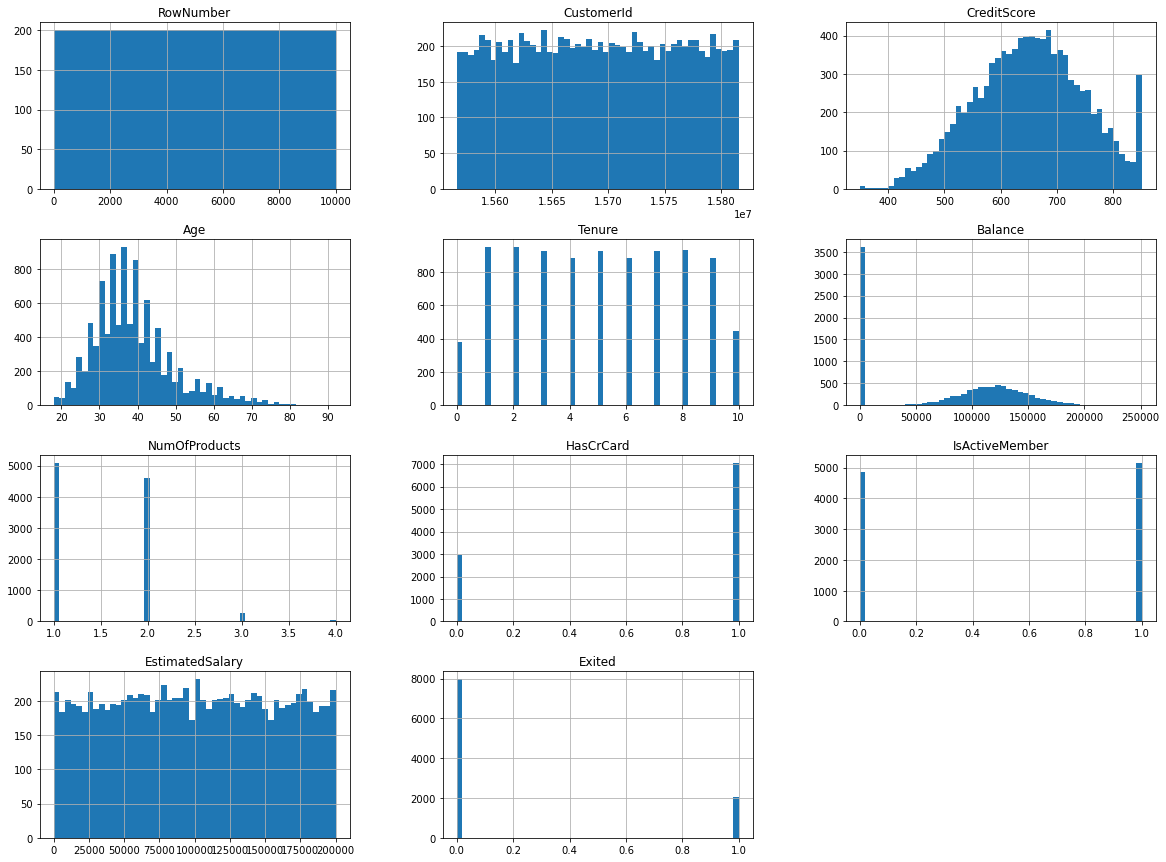

In [5]:
df.hist(figsize=(20, 15), bins=50)
plt.show()

In [6]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,9091.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,4.997690,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.894723,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,2.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


---
**Вывод:** изучив основную информацию о датасете, можно утверждать, что
- необходимо будет привести названия столбцов к нижнему регистру;
- в датасете есть 3 признака, лишних для наших целей обучения моделей - "RowNumber", "CustomerId" и "Surname"; 
- данные частично очищены - пропуски находятся только в столбце "Tenure";
- на всякий случай имеет смысл проверить данные на дубликаты;
- необходимо будет привести категориальные признаки "Gender" и "Geography" к числовому формату с помощью методики OHE;
- признак "Age" имеет распределение, сильно скошенное вправо - но мы не будем считать это за выбросы, т.к. следуя здравому смыслу возраст не должен дифференцироваться как "выброс"-"не выброс" (только если он не больше 120 лет);
- у нас имеется дисбаланс классов 1 к 4 (2000 строк с меткой 1 и 8000 строк с меткой 0);
- данные не стандартизированы -, в дальнейшем, исправим это.

### Приведение названия признаков к общему виду

Приведём названия столбцов к нижнему регистру.

In [7]:
df.columns = df.columns.str.lower()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rownumber        10000 non-null  int64  
 1   customerid       10000 non-null  int64  
 2   surname          10000 non-null  object 
 3   creditscore      10000 non-null  int64  
 4   geography        10000 non-null  object 
 5   gender           10000 non-null  object 
 6   age              10000 non-null  int64  
 7   tenure           9091 non-null   float64
 8   balance          10000 non-null  float64
 9   numofproducts    10000 non-null  int64  
 10  hascrcard        10000 non-null  int64  
 11  isactivemember   10000 non-null  int64  
 12  estimatedsalary  10000 non-null  float64
 13  exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


### Поиск дубликатов

Попробуем найти дубликаты по "customerid":

In [8]:
df[df.duplicated(subset=['customerid'])].head()

,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited


По фамилии искать не будем, т.к. вполне могут быть клиенты с одинаковыми фамилиями.

Изучим уникальные значения признаков "gender" и "geography":

In [9]:
df['gender'].unique()

array(['Female', 'Male'], dtype=object)

In [10]:
df['geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

Неявных дубликатов в данных признаках нет.

### Очистка датасета от лишних признаков

Отбросим ненужные нам признаки "rownumber", "customerid" и "surname":


In [11]:
df = df.drop(columns=['rownumber', 'customerid', 'surname'])

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   creditscore      10000 non-null  int64  
 1   geography        10000 non-null  object 
 2   gender           10000 non-null  object 
 3   age              10000 non-null  int64  
 4   tenure           9091 non-null   float64
 5   balance          10000 non-null  float64
 6   numofproducts    10000 non-null  int64  
 7   hascrcard        10000 non-null  int64  
 8   isactivemember   10000 non-null  int64  
 9   estimatedsalary  10000 non-null  float64
 10  exited           10000 non-null  int64  
dtypes: float64(3), int64(6), object(2)
memory usage: 859.5+ KB


### One-Hot Encoding

Мы создадим бинарные числовые признаки из категориальных "gender" и "geography" в ходе preprocessing-шага для нашего pipeline. На этапе подготовки данных мы не будем создавать бинарные признаки во избежании утечки данных.

### Разбиение данных на выборки

Разобьём наш датасет на обучающую и тестовую выборки. Поскольку мы будем использовать GridSearchCV, на валидационную выборку нам нет необходимости разбивать - обучающий набор будем автоматически разбиваться ещё и на валидационную выборку во время кросс-валидации.

In [13]:
features = df.drop('exited', axis=1)
target = df['exited']

X_train, X_test, y_train, y_test = train_test_split(
                                        features,
                                        target,
                                        train_size=0.8,
                                        random_state=42,
                                        stratify=target)

In [14]:
print(f'Общее количество меток обучающего набора: {np.unique(y_train, return_counts=True)}')
print(f'Доля меток со значением "1": {y_train.mean()}')
print('-' * 37)
print(f'Общее количество меток тестового набора: {np.unique(y_test, return_counts=True)}')
print(f'Доля меток со значением "1": {y_test.mean()}')

Общее количество меток обучающего набора: (array([0, 1]), array([6370, 1630]))
Доля меток со значением "1": 0.20375
-------------------------------------
Общее количество меток тестового набора: (array([0, 1]), array([1593,  407]))
Доля меток со значением "1": 0.2035


### Заполнение пропусков

Изучим пропуски.

In [15]:
df.isna().sum()

creditscore          0
geography            0
gender               0
age                  0
tenure             909
balance              0
numofproducts        0
hascrcard            0
isactivemember       0
estimatedsalary      0
exited               0
dtype: int64

Около 9% строк с пропущенным "tenure". Взглянем на данные с пропусками.

In [16]:
df[df['tenure'].isna()].head(30)

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
30,591,Spain,Female,39,NaN,0.00,3,1,0,140469.38,1
48,550,Germany,Male,38,NaN,103391.38,1,0,1,90878.13,0
51,585,Germany,Male,36,NaN,146050.97,2,0,0,86424.57,0
53,655,Germany,Male,41,NaN,125561.97,1,0,0,164040.94,1
60,742,Germany,Male,35,NaN,136857.00,1,0,0,84509.57,0
82,543,France,Female,36,NaN,0.00,2,0,0,26019.59,0
85,652,Spain,Female,75,NaN,0.00,2,1,1,114675.75,0
94,730,Spain,Male,42,NaN,0.00,2,0,1,85982.47,0
99,413,France,Male,34,NaN,0.00,2,0,0,6534.18,0
111,538,Germany,Male,39,NaN,108055.10,2,1,0,27231.26,0


Никакой связи пропусков с остальными признаками не видно. Судя по-всему, пропуски обусловлены техническими ошибками/качеством данных из источников.

Заполним пропуски в столбце "tenure" у обучающего и тестового набора. Будем заполнять, используя алгоритм MICE-Случайных Лесов (Multiple Imputation by Chained Equations (MICE)), которая предскажет нам возможное значение "tenure" на основе всех остальных данных (кроме целевой метки, её мы не будем использовать для предсказания - во избежание утечки данных).

Во избежание утечки данных, обучать ImputationKernel мы будем только на обучающей выборке, а выполнять последующий transform будем и на обучающей и на тестовой выборке.

In [17]:
pipe_kernel = mf.ImputationKernel( # ядро для заполнения пропусков
    X_train.drop(columns=['gender', 'geography']), # надо обрезать кат. признаки, ядро их не может обработать
    save_all_iterations=True,
    random_state=42,
    datasets=1)

pipe_imp = Pipeline([ # простенький пайплайн для заполнения пропусков в наборах данных
    ('impute', pipe_kernel)
])

X_train_t = pipe_imp.fit_transform( # выполняем fit_transform на обучающем наборе
    X_train.drop(columns=['gender', 'geography']),
    impute__iterations=2
    )
X_train_t = pd.concat( # восстанавливаем категориальные признаки
    [
        X_train_t, 
        X_train[['gender', 'geography']]
    ],
    axis=1) 

X_test_t = pipe_imp.transform(X_test.drop(columns=['gender', 'geography'])) # только transform на тестовом наборе
X_test_t = pd.concat( # восстанавливаем категориальные признаки
    [
        X_test_t,
        X_test[['gender', 'geography']]
    ],
    axis=1) 

In [18]:
X_train_t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8000 entries, 2151 to 6206
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   creditscore      8000 non-null   int64  
 1   age              8000 non-null   int64  
 2   tenure           8000 non-null   float64
 3   balance          8000 non-null   float64
 4   numofproducts    8000 non-null   int64  
 5   hascrcard        8000 non-null   int64  
 6   isactivemember   8000 non-null   int64  
 7   estimatedsalary  8000 non-null   float64
 8   gender           8000 non-null   object 
 9   geography        8000 non-null   object 
dtypes: float64(3), int64(5), object(2)
memory usage: 687.5+ KB


In [19]:
X_test_t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 5702 to 3776
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   creditscore      2000 non-null   int64  
 1   age              2000 non-null   int64  
 2   tenure           2000 non-null   float64
 3   balance          2000 non-null   float64
 4   numofproducts    2000 non-null   int64  
 5   hascrcard        2000 non-null   int64  
 6   isactivemember   2000 non-null   int64  
 7   estimatedsalary  2000 non-null   float64
 8   gender           2000 non-null   object 
 9   geography        2000 non-null   object 
dtypes: float64(3), int64(5), object(2)
memory usage: 171.9+ KB


Проверим, не сместились ли у нас медиана, среднее и дисперсия:

In [20]:
X_train['tenure'].describe()

count    7271.000000
mean        4.996012
std         2.899056
min         0.000000
25%         2.000000
50%         5.000000
75%         8.000000
max        10.000000
Name: tenure, dtype: float64

In [21]:
X_train_t['tenure'].describe()

count    8000.000000
mean        4.995250
std         2.889251
min         0.000000
25%         2.000000
50%         5.000000
75%         7.000000
max        10.000000
Name: tenure, dtype: float64

Статистики почти не изменились.

Сохраним трансформированные наборы в старые переменные.

In [22]:
X_train = X_train_t
X_test = X_test_t

Построим график оценки плотности ядра признака "tenure" до (черным цветом) и после (красным цветом) заполнения пропусков.

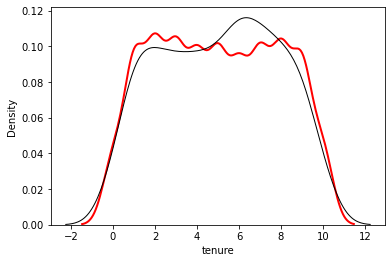

In [23]:
pipe_kernel.plot_imputed_distributions(wspace=0.3,hspace=0.3)

Плотность ядра почти не сместилась.

Мы заполнили пропуски.

### Корреляция признаков

Проверим наши данные на мультиколлинеарность - построим тепловую карту корреляций.

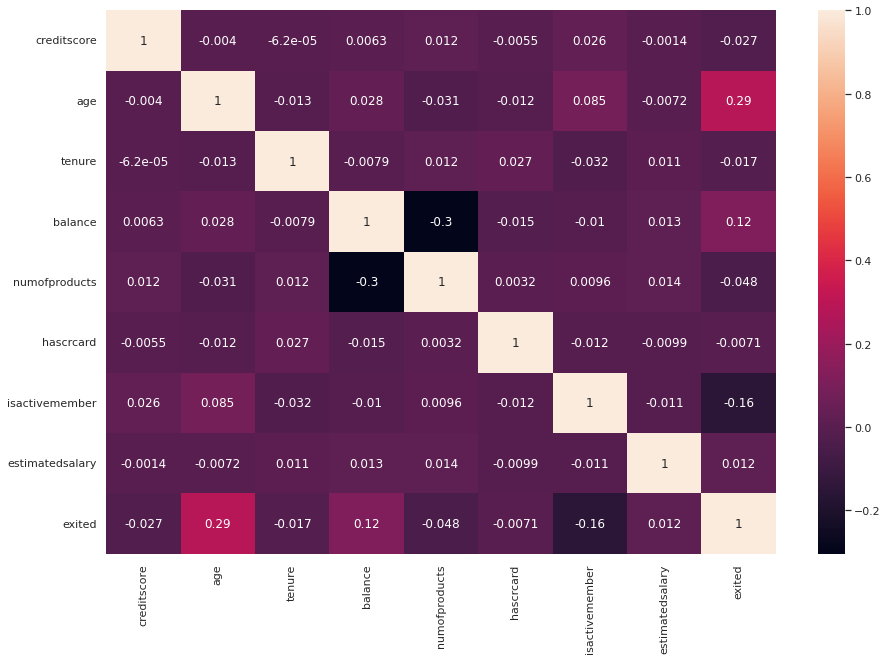

In [24]:
sns.set(rc={'figure.figsize':(15,10)})
sns.heatmap(df.corr(), annot=True)
plt.show()

Значительных (>0.8 по модулю) значений корреляции нет, проблемы мультиколлинеарности в нашем проекте нет.

---
**Выводы по этапу подготовки данных:** 
- названия всех признаков приведены к единому формату;
- в датасете явных и неявных дубликатов не обнаружено; 
- были удалены лишние для целей обучения моделей признаки "rownumber", "customerid" и "surname";
- с помощью техники OHE на основе категориальных признаков "gender" и "geography" будут созданы новые бинарные признаки в ходе последующего этапа;
- данные разбиты на обучающую и тестовую выборку; обучающая будет разбиваться ещё и на валидационную в ходе кросс-валидации во время обучения моделей;
- с помощью алгоритма MICE forest были заполнены пропуски в признаке "tenure" у обучающей и тестовой выборки так, чтобы не возникла утечка данных;
- признаки проверены на мультиколлинеарность, её нет.

## Исследование задачи

### Исследование баланса классов

Взглянем ещё раз на распределение целевых меток:

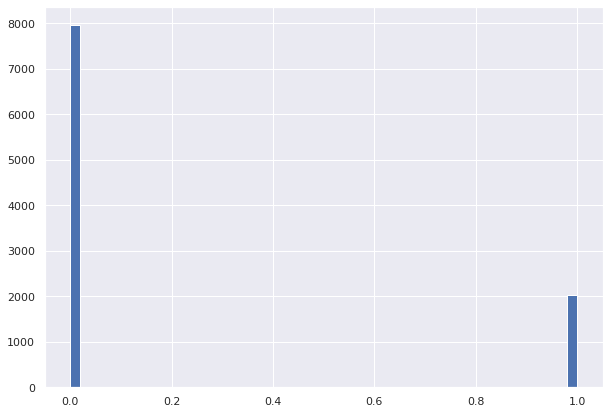

In [25]:
target.hist(figsize=(10, 7), bins=50)
plt.show()

Как мы видим, у нас имеется дисбаланс классов в соотношении 1 к 4 (2000 меток со значением "1" и 8000 с "0"). Это скажется на качестве моделей.

Но в начале, попробуем обучить наши модели без учёта дисбаланса.

### Подготовка preprocessing-шага для pipeline'а

Подготовим preprocessing-шаг для наших pipeline'ов.

В preprocessing-шаге мы будем стандартизировать числовые признаки (но не бинарные и категориальные) и переводить категориальные в бинарные с помощью OHE.

В последующих pipeline'ах мы будем постоянно использовать этот шаг.

In [26]:
numeric_features = ['creditscore', 'age', 'tenure', 'balance', 'estimatedsalary'] # числовые признаки
numeric_transformer = Pipeline( # трансформер для числовых признаков
    steps=[
        ('scaler', StandardScaler()) # Стандартизация для числовых признаков
    ]
)

categorical_features = ['gender', 'geography'] # категориальные признаки
categorical_transformer = Pipeline( # трансформер для категориальных признаков
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")) # ОХЕ для категориальных признаков
    ]
)

preprocessor = ColumnTransformer( # препроцессор, комбинированный из наших трансформеров
    transformers=[
        ('num', numeric_transformer, numeric_features), # Трансформер со стандартизацией для числовых признаков
        ('cat', categorical_transformer, categorical_features) # Трансформер с ОХЕ с категориальных признаков
    ],
    remainder='passthrough' # неуказанные признаки не обрезать, а передавать дальше
)


### Изучение моделей без учёта дисбаланса

#### Дерево решений

У Дерева решений мы будем подбирать следующие гиперпараметры:
- критерий (джини или энтропии);
- глубина дерева (от 4 до 12).

Для обучения модели мы будем использовать GridSearchCV с кросс-валидацией в пайплайне с препроцессингом данных.

In [27]:
%%time

dtc_pipe = Pipeline(steps = [ # Создаём pipeline
    ['preprocessor', preprocessor], # Указываем ранее созданный препроцессор
    ['model', DecisionTreeClassifier()]]) # Указываем модель, которую будем обучать

parameter_space = { # Указываем пространство гиперпараметров, которые будем перебирать
    'model__criterion' : ['gini', 'entropy'],
    'model__max_depth' : range(4, 13, 1),
    'model__random_state' : [42]
}

dtc_grid = GridSearchCV(dtc_pipe, parameter_space, scoring='f1', cv=5) # Инициализируем GridSearchCV

dtc_grid.fit(X_train, y_train) # Обучаем модель

best_dtc = dtc_grid.best_estimator_ # Выводим лучшие параметры в переменную для визуализации
best_f1_score = dtc_grid.best_score_ # Выводим лучший score в переменную для визуализации
best_roc_auc = cross_val_score( # Считаем кросс-валидационный РОК-АУК для статистики            
    dtc_grid,
    X_train,
    y_train,
    cv=5, scoring='roc_auc').mean() 

CPU times: user 14.5 s, sys: 36.4 ms, total: 14.6 s
Wall time: 14.6 s


In [28]:
print(f'Лучшая модель дерева решений показала f1-меру: {best_f1_score} и AUC-ROC: {best_roc_auc}.')
print(f'Гиперпараметры:')
best_dtc

Лучшая модель дерева решений показала f1-меру: 0.568312724064159 и AUC-ROC: 0.813937311592877.
Гиперпараметры:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['creditscore', 'age',
                                                   'tenure', 'balance',
                                                   'estimatedsalary']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'geography'])])),
                ['model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=7,
                                        random_state=42)]])

#### Случайный лес

У Случайного леса мы будем подбирать следующие гиперпараметры:
- критерий (джини или энтропии);
- глубина деревьев (от 7 до 12);
- максимальное количество признаков у каждого дерева (4-6);
- количество деревьев (30, 40, 50, 60).

Для обучения модели мы будем использовать GridSearchCV с кросс-валидацией в пайплайне с препроцессингом данных.

In [29]:
%%time

rfc_pipe = Pipeline(steps = [
    ['preprocessor', preprocessor],
    ['model', RandomForestClassifier()]])

parameter_space = {
    'model__criterion' : ['gini', 'entropy'],
    'model__max_depth' : range(7, 13, 1),
    'model__n_estimators' : range(30, 60, 10),
    'model__max_features' : [4, 5, 6],
    'model__random_state' : [42]
}

rfc_grid = GridSearchCV(rfc_pipe, parameter_space, scoring='f1', cv=5)

rfc_grid.fit(X_train, y_train)

best_rfc = rfc_grid.best_estimator_
best_f1_score = rfc_grid.best_score_
best_roc_auc = cross_val_score(rfc_grid, X_train, y_train, cv=5, scoring='roc_auc').mean()

CPU times: user 12min 5s, sys: 1.16 s, total: 12min 7s
Wall time: 12min 7s


In [30]:
print(f'Лучшая модель случайного леса показала f1-меру: {best_f1_score} и AUC-ROC: {best_roc_auc}.')
print(f'Гиперпараметры:')
best_rfc

Лучшая модель случайного леса показала f1-меру: 0.5787192272995528 и AUC-ROC: 0.8577910258015429.
Гиперпараметры:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['creditscore', 'age',
                                                   'tenure', 'balance',
                                                   'estimatedsalary']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'geography'])])),
                ['model',
                 RandomForestClassifier(criterion='entropy', max_depth=12,
                                        max_features=6, n_estimators=30,
                                        random_state=42)]])

#### Логистическая регрессия

У Логистической регрессии мы будем подбирать следующие гиперпараметры:
- C-параметр, обратная сила регуляризации;
- алгоритм оптимизации ('lbfgs', 'liblinear').

Для обучения модели мы будем использовать GridSearchCV с кросс-валидацией в пайплайне с препроцессингом данных.

In [31]:
%%time

lr_pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', LogisticRegression())
])

parameter_space = {
    'model__C'       : np.logspace(0.1,10,1),
    'model__solver'  : ['lbfgs', 'liblinear'],
    'model__random_state' : [42]
}

lr_grid = GridSearchCV(lr_pipe, parameter_space, scoring='f1', cv=5)

lr_grid.fit(X_train, y_train)

best_lr = lr_grid.best_estimator_
best_f1_score = lr_grid.best_score_
best_roc_auc = cross_val_score(lr_grid, X_train, y_train, cv=5, scoring='roc_auc').mean()

CPU times: user 1.24 s, sys: 3.99 ms, total: 1.24 s
Wall time: 1.24 s


In [32]:
print(f'Лучшая модель логистической регрессии показала f1-меру: {best_f1_score} и AUC-ROC: {best_roc_auc}.')
print(f'Гиперпараметры:')
best_lr

Лучшая модель логистической регрессии показала f1-меру: 0.3165680139979795 и AUC-ROC: 0.7634468511330913.
Гиперпараметры:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['creditscore', 'age',
                                                   'tenure', 'balance',
                                                   'estimatedsalary']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'geography'])])),
                ('model',
                 LogisticRegression(C=1.2589254117941673, random_state=42))])

#### Градиентный бустинг

У Градиентного бустинга мы будем подбирать следующие гиперпараметры:

- глубина деревьев (от 4 до 10);
- количество деревьев (100, 300, 500).

Для обучения модели мы будем использовать GridSearchCV с кросс-валидацией в пайплайне с препроцессингом данных.

In [33]:
%%time

lgbm_pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', LGBMClassifier())
])

parameter_space = {
    'model__boosting_type' : ['gbdt'], 
    'model__max_depth'     : range(4, 10, 1),
    'model__n_estimators'  : [100, 300, 500],
    'model__random_state' : [42]
}

lgbm_grid = GridSearchCV(lgbm_pipe, parameter_space, scoring='f1', cv=5)

lgbm_grid.fit(X_train, y_train)

best_lgbm = lgbm_grid.best_estimator_
best_f1_score = lgbm_grid.best_score_
best_roc_auc = cross_val_score(lgbm_grid, X_train, y_train, cv=5, scoring='roc_auc').mean()

CPU times: user 25min 36s, sys: 12.9 s, total: 25min 49s
Wall time: 1min 37s


In [34]:
print(f'Лучшая модель градиентного бустинга показала f1-меру: {best_f1_score} и AUC-ROC: {best_roc_auc}.')
print(f'Гиперпараметры:')
best_lgbm

Лучшая модель градиентного бустинга показала f1-меру: 0.5906608310453898 и AUC-ROC: 0.8579393437412719.
Гиперпараметры:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['creditscore', 'age',
                                                   'tenure', 'balance',
                                                   'estimatedsalary']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'geography'])])),
                ('model',
                 LGBMClassifier(max_depth=4, n_estimators=300,
                                random_state=42))])

#### Многослойный перцептрон

У Многослойного перцептрона мы будем подбирать следующие гиперпараметры:

- архитектуру скрытых слоёв (2 или 3 слоя с количеством нейронов 100-50 и 150-100-50);
- функцию активации (логистическая, гиперболический тангенс и ReLu);
- альфа для штрафа регуляризации l2 (0.001 и 0.01);
- скорость обучения (0.01 и 0.1).

Для обучения модели мы будем использовать GridSearchCV с кросс-валидацией в пайплайне с препроцессингом данных.

In [35]:
%%time

mlp_pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', MLPClassifier())
])

parameter_space = {
    'model__hidden_layer_sizes' : [(100, 50,), (150, 100, 50,)],
    'model__solver' : ['adam'],
    'model__alpha' : [0.001, 0.01],
    'model__activation' : ['logistic', 'tanh', 'relu'],
    'model__learning_rate_init' : [0.01, 0.1],
    'model__learning_rate' : ['adaptive'],
    'model__max_iter' : [500], 
    'model__early_stopping' : [True],
    'model__validation_fraction' : [0.1],
    'model__random_state' : [42]
}

mlp_grid = GridSearchCV(mlp_pipe, parameter_space, scoring='f1', cv=5)

mlp_grid.fit(X_train, y_train)

best_mlp = mlp_grid.best_estimator_
best_f1_score = mlp_grid.best_score_
best_roc_auc = cross_val_score(mlp_grid, X_train, y_train, cv=5, scoring='roc_auc').mean()

CPU times: user 1h 17min 26s, sys: 1min 34s, total: 1h 19min 1s
Wall time: 9min 52s


In [36]:
print(f'Лучшая модель многослойного перцептрона показала f1-меру: {best_f1_score} и AUC-ROC: {best_roc_auc}.')
print(f'Гиперпараметры:')
best_mlp

Лучшая модель многослойного перцептрона показала f1-меру: 0.5731175380510973 и AUC-ROC: 0.85083212142809.
Гиперпараметры:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['creditscore', 'age',
                                                   'tenure', 'balance',
                                                   'estimatedsalary']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'geography'])])),
                ('model',
                 MLPClassifier(activation='tanh', alpha=0.001,
                               early_stopping=True,
                               hidden_layer_sizes=(150, 100, 50),
                               learning_rate='adaptive',
                               learning_rate_init=0.01, max_iter=500,
                               random_state=42))])

---
**Выводы:** без учёта дисбаланса классов лучше всех проявила себя модель Градиентного бустинга, которая сумела показать требуемый результат f1-меры 0.59 и AUC-ROC 0.86. Все остальные модели показали себя хуже, но не намного - на 1-2 сотых. Кроме логистической регресии - модель явно не справляется из-за нелинейности задачи (всего 0.32 f1 и 0.76 auc-roc).

## Борьба с дисбалансом

В ходе этого этапа мы опробуем 2 техники борьбы с дисбалансом: 
- взвешивание классов (с помощью гиперпараметров моделей);
- oversampling (с помощью техники SMOTE) и одновременный undersampling с помощью RandomUnderSampler'а.

### Взвешивание классов

Начнём с простого взвешивания. Мы испытаем его на моделях:
- Дерева решений;
- Случайного леса;
- Градиентного бустинга.

Мы не будем испытывать его на модели логистической регрессии, поскольку она явно не справляется из-за того, что задача нелинейна. 

Нам не получится испытать Многослойный перцептрон, т.к. он не поддерживает взвешивание классов.

#### Дерево решений

Добавим в дерево решений гиперпараметр class_weight='balanced'.

In [37]:
%%time

dtc_pipe_bal = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', DecisionTreeClassifier())
])

parameter_space = {
    'model__criterion' : ['gini', 'entropy'],
    'model__max_depth' : range(4, 13, 1),
    'model__random_state' : [42],
    'model__class_weight' : ['balanced']
}

dtc_grid_bal = GridSearchCV(dtc_pipe_bal, parameter_space, scoring='f1', cv=5)

dtc_grid_bal.fit(X_train, y_train)

best_dtc_bal = dtc_grid_bal.best_estimator_
best_f1_score = dtc_grid_bal.best_score_
best_roc_auc = cross_val_score(dtc_grid_bal, X_train, y_train, cv=5, scoring='roc_auc').mean()

CPU times: user 15.4 s, sys: 51.7 ms, total: 15.5 s
Wall time: 14.6 s


In [38]:
print(f'Лучшая модель дерева решений показала f1-меру: {best_f1_score} и AUC-ROC: {best_roc_auc}.')
print(f'Гиперпараметры:')
best_dtc_bal

Лучшая модель дерева решений показала f1-меру: 0.5648399224984267 и AUC-ROC: 0.8324503279367435.
Гиперпараметры:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['creditscore', 'age',
                                                   'tenure', 'balance',
                                                   'estimatedsalary']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'geography'])])),
                ('model',
                 DecisionTreeClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=6,
                                        random_state=42))])

#### Случайный лес

Добавим в Случайный лес гиперпараметр class_weight='balanced'.

In [39]:
%%time

rfc_pipe_bal = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', RandomForestClassifier())
])

parameter_space = {
    'model__criterion' : ['gini', 'entropy'],
    'model__max_depth' : range(7, 13, 1),
    'model__n_estimators' : range(30, 60, 10),
    'model__max_features' : [4, 5, 6],
    'model__random_state' : [42],
    'model__class_weight' : ['balanced']
}

rfc_grid_bal = GridSearchCV(rfc_pipe_bal, parameter_space, scoring='f1', cv=5)

rfc_grid_bal.fit(X_train, y_train)

best_rfc_bal = rfc_grid_bal.best_estimator_
best_f1_score = rfc_grid_bal.best_score_
best_roc_auc = cross_val_score(rfc_grid_bal, X_train, y_train, cv=5, scoring='roc_auc').mean()

CPU times: user 12min 3s, sys: 1.31 s, total: 12min 5s
Wall time: 12min 5s


In [40]:
print(f'Лучшая модель случайного леса показала f1-меру: {best_f1_score} и AUC-ROC: {best_roc_auc}.')
print(f'Гиперпараметры:')
best_rfc_bal

Лучшая модель случайного леса показала f1-меру: 0.6248916040134023 и AUC-ROC: 0.8587483506852482.
Гиперпараметры:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['creditscore', 'age',
                                                   'tenure', 'balance',
                                                   'estimatedsalary']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'geography'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        max_features=4, n_estimators=50,
                                        random_state=42))])

#### Градиентный бустинг

Добавим в Градиентный бустинг гиперпараметр is_unbalance=True.

In [41]:
%%time

lgbm_pipe_bal = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', LGBMClassifier())
])

parameter_space = {
    'model__boosting_type' : ['gbdt'], 
    'model__max_depth'     : range(4, 10, 1),
    'model__n_estimators'  : [100, 300, 500],
    'model__random_state' : [42],
    'model__is_unbalance' : [True]
}

lgbm_grid_bal = GridSearchCV(lgbm_pipe_bal, parameter_space, scoring='f1', cv=5)

lgbm_grid_bal.fit(X_train, y_train)

best_lgbm_bal = lgbm_grid_bal.best_estimator_
best_f1_score = lgbm_grid_bal.best_score_
best_roc_auc = cross_val_score(lgbm_grid_bal, X_train, y_train, cv=5, scoring='roc_auc').mean()

CPU times: user 25min 34s, sys: 12.9 s, total: 25min 47s
Wall time: 1min 37s


In [42]:
print(f'Лучшая модель градиентного бустинга показала f1-меру: {best_f1_score} и AUC-ROC: {best_roc_auc}.')
print(f'Гиперпараметры:')
best_lgbm_bal

Лучшая модель градиентного бустинга показала f1-меру: 0.6199555937685831 и AUC-ROC: 0.8577746530419624.
Гиперпараметры:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['creditscore', 'age',
                                                   'tenure', 'balance',
                                                   'estimatedsalary']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'geography'])])),
                ('model',
                 LGBMClassifier(is_unbalance=True, max_depth=8,
                                random_state=42))])

### Oversampling (SMOTE) и undersampling

Для создания большей обучающей выборки мы будем использовать технику SMOTE (Synthetic Minority Oversampling Technique), встроим её прямо в пайплайны наших моделей.

И одновременно, мы будем уменьшать набор меток мажоритарного класса ("0") с помощью RandomUnderSampler.

Общая схема такова: увеличиваем минорный класс ("1") до половины мажоритарного и затем уменьшаем мажоритарный на 50% так, чтобы возник абсолютный баланс классов.

#### Дерево решений

In [43]:
%%time

dtc_pipe_smote = ImbPipeline(steps = [
                        ['preprocessor', preprocessor],
                        ['smote', SMOTE(sampling_strategy=0.5, random_state=42)],
                        ['undersampling', RandomUnderSampler(sampling_strategy=1.0, random_state=42)],
                        ['model', DecisionTreeClassifier()]])

parameter_space = {
    'model__criterion' : ['gini', 'entropy'],
    'model__max_depth' : range(4, 13, 1),
    'model__random_state' : [42]
}

dtc_grid_up = GridSearchCV(dtc_pipe_smote, parameter_space, scoring='f1', cv=5)

dtc_grid_up.fit(X_train, y_train)

best_dtc_up = dtc_grid_up.best_estimator_
best_f1_score = dtc_grid_up.best_score_
best_roc_auc = cross_val_score(dtc_grid_up, X_train, y_train, cv=5, scoring='roc_auc').mean()

CPU times: user 27.4 s, sys: 99.6 ms, total: 27.5 s
Wall time: 25.5 s


In [44]:
print(f'Лучшая модель дерева решений показала f1-меру: {best_f1_score} и AUC-ROC: {best_roc_auc}.')
print(f'Гиперпараметры:')
best_dtc_up

Лучшая модель дерева решений показала f1-меру: 0.5874907196394549 и AUC-ROC: 0.8344677890032841.
Гиперпараметры:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['creditscore', 'age',
                                                   'tenure', 'balance',
                                                   'estimatedsalary']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'geography'])])),
                ('smote', SMOTE(random_state=42, sampling_strategy=0.5)),
                ('undersampling',
                 RandomUnderSampler(random_state=42, sampling_strategy=1.0)),
                ['model',
                 DecisionTreeClassifier(criterion='entropy', max_depth=7,
                                        random_state=42)]])

#### Случайный лес

In [45]:
%%time

rfc_pipe_smote = ImbPipeline(steps = [
                        ['preprocessor', preprocessor],
                        ['smote', SMOTE(sampling_strategy=0.5, random_state=42)],
                        ['undersampling', RandomUnderSampler(sampling_strategy=1.0, random_state=42)],
                        ['model', RandomForestClassifier()]])

parameter_space = {
    'model__criterion' : ['gini', 'entropy'],
    'model__max_depth' : range(7, 13, 1),
    'model__n_estimators' : range(30, 60, 10),
    'model__max_features' : [4, 5, 6],
    'model__random_state' : [42]
}

rfc_grid_up = GridSearchCV(rfc_pipe_smote, parameter_space, scoring='f1', cv=5)

rfc_grid_up.fit(X_train, y_train)

best_rfc_up = rfc_grid_up.best_estimator_
best_f1_score = rfc_grid_up.best_score_
best_roc_auc = cross_val_score(rfc_grid_up, X_train, y_train, cv=5, scoring='roc_auc').mean()

CPU times: user 12min 3s, sys: 1.33 s, total: 12min 4s
Wall time: 12min 4s


In [46]:
print(f'Лучшая модель случайного леса показала f1-меру: {best_f1_score} и AUC-ROC: {best_roc_auc}.')
print(f'Гиперпараметры:')
best_rfc_up

Лучшая модель случайного леса показала f1-меру: 0.6191407457357884 и AUC-ROC: 0.856163380878543.
Гиперпараметры:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['creditscore', 'age',
                                                   'tenure', 'balance',
                                                   'estimatedsalary']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'geography'])])),
                ('smote', SMOTE(random_state=42, sampling_strategy=0.5)),
                ('undersampling',
                 RandomUnderSampler(random_state=42, sampling_strategy=1.0)),
                ['model',
                 RandomForestClassifier(max_depth=7, max_features=4,
                                        n_estimators=40, random_state=42)]])

#### Градиентный бустинг

In [47]:
%%time

lgbm_pipe_smote = ImbPipeline(steps = [
                        ['preprocessor', preprocessor],
                        ['smote', SMOTE(sampling_strategy=0.5, random_state=42)],
                        ['undersampling', RandomUnderSampler(sampling_strategy=1.0, random_state=42)],
                        ['model', LGBMClassifier()]])

parameter_space = {
    'model__boosting_type' : ['gbdt'], 
    'model__max_depth'     : range(4, 10, 1),
    'model__n_estimators'  : [100, 300, 500],
    'model__random_state' : [42]
}

lgbm_grid_up = GridSearchCV(lgbm_pipe_smote, parameter_space, scoring='f1', cv=5)

lgbm_grid_up.fit(X_train, y_train)

best_lgbm_up = lgbm_grid_up.best_estimator_
best_f1_score = lgbm_grid_up.best_score_
best_roc_auc = cross_val_score(lgbm_grid_up, X_train, y_train, cv=5, scoring='roc_auc').mean()

CPU times: user 35min 17s, sys: 25 s, total: 35min 42s
Wall time: 2min 16s


In [48]:
print(f'Лучшая модель градиентного бустинга показала f1-меру: {best_f1_score} и AUC-ROC: {best_roc_auc}.')
print(f'Гиперпараметры:')
best_lgbm_up

Лучшая модель градиентного бустинга показала f1-меру: 0.6189833249423414 и AUC-ROC: 0.8603526403482583.
Гиперпараметры:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['creditscore', 'age',
                                                   'tenure', 'balance',
                                                   'estimatedsalary']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'geography'])])),
                ('smote', SMOTE(random_state=42, sampling_strategy=0.5)),
                ('undersampling',
                 RandomUnderSampler(random_state=42, sampling_strategy=1.0)),
                ['model', LGBMClassifier(max_depth=5, random_state=42)]])

#### Многослойный перцептрон

In [49]:
%%time

mlp_pipe_smote = ImbPipeline(steps = [
                        ['preprocessor', preprocessor],
                        ['smote', SMOTE(sampling_strategy=0.5, random_state=42)],
                        ['undersampling', RandomUnderSampler(sampling_strategy=1.0, random_state=42)],
                        ['model', MLPClassifier()]])

parameter_space = {
    'model__hidden_layer_sizes' : [(100, 50,), (150, 100, 50,)],
    'model__solver' : ['adam'],
    'model__alpha' : [0.001, 0.01],
    'model__activation' : ['logistic', 'tanh', 'relu'],
    'model__learning_rate_init' : [0.01, 0.1],
    'model__learning_rate' : ['adaptive'],
    'model__max_iter' : [500], 
    'model__early_stopping' : [True],
    'model__validation_fraction' : [0.1],
    'model__random_state' : [42]
}

mlp_grid_up = GridSearchCV(mlp_pipe_smote, parameter_space, scoring='f1', cv=5)

mlp_grid_up.fit(X_train, y_train)

best_mlp_up = mlp_grid_up.best_estimator_
best_f1_score = mlp_grid_up.best_score_
best_roc_auc = cross_val_score(mlp_grid_up, X_train, y_train, cv=5, scoring='roc_auc').mean()

CPU times: user 1h 26min 5s, sys: 1min 45s, total: 1h 27min 50s
Wall time: 10min 58s


In [50]:
print(f'Лучшая модель многослойного перцептрона показала f1-меру: {best_f1_score} и AUC-ROC: {best_roc_auc}.')
print(f'Гиперпараметры:')
best_mlp_up

Лучшая модель многослойного перцептрона показала f1-меру: 0.583644847471862 и AUC-ROC: 0.8432915025377777.
Гиперпараметры:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['creditscore', 'age',
                                                   'tenure', 'balance',
                                                   'estimatedsalary']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'geography'])])),
                ('smote', SMOTE(random_state=42, sampling_strategy=0.5)),
                ('undersampling',
                 RandomUnderSampler(random_state=42, sampling_strategy=1.0)),
                ['model',
                 MLPClassifier(activation='logistic', alpha=0.001,
                               early_stopping=True,
                               hidden_layer_sizes=(100, 50),
                               learning_rate='adaptive',
                               learning_rate_init=0.01, max_iter=500,
                               random_state=42)]])

---
**Выводы:** в ходе борбы с дисбалансом мы добились требуемых значений f1-меры у Случайного леса и у Градиентного бустинга. Случайный лес даёт значения 0.63 (в случае взвешивания классов) и 0.62 (в случае оверсемплирования с андерсемплированием) f1-меры и AUC-ROC 0.86. Градиентный бустинг даёт 0.62 f1-меры и в том и в другом случае и 0.86 AUC-ROC. 

## Тестирование модели

### Тестирование

Мы выбираем в качестве лучшей модели Градиентный бустинг, обученный на наборе данных, который подвергся обработке SMOTE и RandomUnderSampler.

Проверим F1-меру на тестовом наборе данных:

In [51]:
predicted_values = lgbm_grid_up.predict(X_test)
f1_score(y_test, predicted_values)

0.6211453744493393

А теперь AUC-ROC:

In [52]:
probabilities_valid = lgbm_grid_up.predict_proba(X_test)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc = roc_auc_score(y_test, probabilities_one_valid)

print(auc_roc)

0.8675424268644608


Наша модель Градиентного бустинга показала требуемый результат! F1-мера со значением **0.62** и AUC-ROC **0.87**.

### Проверка на адекватность

Проверим нашу модель на адекватность. Построим модель-пустышку, которая всегда будет выдавать метку класса "1" и посчитаем её f1-меру и AUC-ROC.

In [53]:
%%time

dummy_pipe = Pipeline(steps = [
    ['preprocessor', preprocessor],
    ['model', DummyClassifier()]])

parameter_space = {
    'model__strategy' : ['constant'],
    'model__constant' : [1],
    'model__random_state' : [42]
}

dummy_grid = GridSearchCV(dummy_pipe, parameter_space, scoring='f1', cv=5)

dummy_grid.fit(X_train, y_train)

best_dummy = dummy_grid.best_estimator_
best_f1_score = dummy_grid.best_score_
best_roc_auc = cross_val_score(dummy_grid, X_train, y_train, cv=5, scoring='roc_auc').mean()

CPU times: user 2.8 s, sys: 112 ms, total: 2.91 s
Wall time: 488 ms


In [54]:
print(f'Лучшая модель-пустышка показала f1-меру: {best_f1_score} и AUC-ROC: {best_roc_auc}.')
print(f'Гиперпараметры:')
best_dummy

Лучшая модель-пустышка показала f1-меру: 0.33852544132917967 и AUC-ROC: 0.5.
Гиперпараметры:


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['creditscore', 'age',
                                                   'tenure', 'balance',
                                                   'estimatedsalary']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'geography'])])),
                ['model',
                 DummyClassifier(constant=1, random_state=42,
                                 strategy='constant')]])

Теперь проверим пустышку на тестовом наборе:

In [55]:
predicted_values = dummy_grid.predict(X_test)
f1_score(y_test, predicted_values)

0.3381803074366431

Как мы видим, значение нашей выбранной лучшей модели отличается от пустышки в 2 раза.

Наша модель адекватна.

## Общий вывод

Сначало, отвечая на главный вопрос проекта - "нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет": мы обучили модель Градиентного бустинга, используя для борьбы с дисбалансом классов техники SMOTE и андерсэмплирования и получили значения F1-меры **0.62** и AUC-ROC **0.87**. Предлагаем для прогнозов использовать данную модель.

В целом,
- в ходе этапа подготовки данных: 
    - названия всех признаков были приведены к единому формату;
    - в датасете явных и неявных дубликатов не обнаружено; 
    - были удалены лишние для целей обучения моделей признаки "rownumber", "customerid" и "surname";
    - с помощью техники OHE на основе категориальных признаков "gender" и "geography" будут созданы новые бинарные признаки в ходе последующего этапа;
    - данные разбиты на обучающую и тестовую выборку; обучающая будет разбиваться ещё и на валидационную в ходе кросс-валидации во время обучения моделей;
    - с помощью алгоритма MICE forest были заполнены пропуски в признаке "tenure" у обучающей и тестовой выборки так, чтобы не возникла утечка данных;
    - признаки проверены на мультиколлинеарность, её нет.
    
    
- в ходе этапа исследования задачи:
    - мы обнаружили, что имеется дисбаланс классов в соотношении 1 к 4 (2000 меток со значением "1" и 8000 с "0"); это скажется на качестве моделей;
    - мы подготовили preprocessing-шаг, в котором стандартизируются числовые признаки (но не бинарные и категориальные) и переводятся категориальные в бинарные с помощью OHE; это сделано с учётом недопущения утечек данных;
    - без учёта дисбаланса классов лучше всех проявила себя модель Градиентного бустинга, которая сумела показать требуемый результат f1-меры 0.59 и AUC-ROC 0.86. Все остальные модели показали себя хуже, но не намного - на 1-2 сотых. Кроме логистической регресии - модель явно не справляется из-за нелинейности задачи (всего 0.32 f1 и 0.76 auc-roc).
    
    
- в ходе этапа борьбы с дисбалансом:    
    - мы опробовали 2 способа - взвешивание классов (с помощью гиперпараметров моделей) и oversampling (с помощью техники SMOTE) с одновременным undersampling'ом с помощью RandomUnderSampler'а;
    - мы добились требуемых значений f1-меры у Случайного леса и у Градиентного бустинга. Случайный лес даёт значения f1-меры 0.63 (в случае взвешивания классов) и 0.62 (в случае оверсемплирования с андерсемплированием) и AUC-ROC 0.86. Градиентный бустинг даёт 0.62 f1-меры и в том и в другом случае и 0.86 AUC-ROC.
    
    
- в ходе этапа тестирования модели:
    - мы выбрали модель Градиентного бустинга, обученную на данных, подвергшихся SMOTE и RandomUnderSampler, получили значения F1-меры **0.62** и AUC-ROC **0.87** на тестовом наборе данных;
    - проверили модель на адекватность, она прошла проверку.